## Computing PSD with Welch's 
Website used for reference:
[Compute the average bandpower of an EEG signal](https://raphaelvallat.com/bandpower.html)

In [3]:
import pickle
import numpy as np
import pandas as pd

# load all raw data from DEAP dataset
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')
data = x['data']
labels = x['labels']

relevant_channels = data[:, :32, :]
relevant_labels = labels[:, :2]

print("Data shape after selecting first 32 channels:", relevant_channels.shape)
print("Labels shape:", relevant_labels.shape)


Data shape after selecting first 32 channels: (40, 32, 8064)
Labels shape: (40, 2)


In [5]:
# Organizing data into dataframes
labels_df = pd.DataFrame(relevant_labels, columns=['valence', 'arousal'])

trials_dfs = []
for i in range(40):
    eeg_df = pd.DataFrame(relevant_channels[i, :, :])
    trials_dfs.append(eeg_df)

Data shape: (32, 8064)
Frequencies shape: (1025,)
PSD shape: (32, 1025)


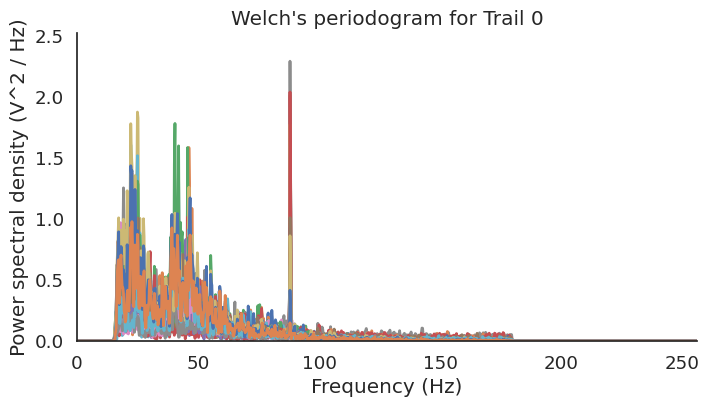

In [ ]:
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt

window_length = 4 * 512 # seconds * sample frequency
                        # seconds = two cycles of lowest frequency = 2/0.5 = 4
frequencies, psd = signal.welch(trials_dfs[0], 512, nperseg=window_length)

# example of using Welch's method to view PSD for all frequencies in first trial, first subject
print("Data shape:", trials_dfs[0].shape)
print("Frequencies shape:", frequencies.shape)
print("PSD shape:", psd.shape)
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
for channel_psd in psd:
    plt.plot(frequencies, channel_psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for Trail 0")
plt.xlim([0, frequencies.max()])
sns.despine()

Putting *all* subjects into one dataset

In [ ]:
from scipy.integrate import simpson

psd_data = []

for subject in range(32):
    file_path = f"data_preprocessed_python/s{subject + 1:02}.dat"
    x = pickle.load(open(file_path, 'rb'), encoding='latin1')
    data = x['data']
    labels = x['labels']
    relevant_channels = data[:, :32, :]
    relevant_labels = labels[:, :2]

    for i in range(40):
        eeg_df = pd.DataFrame(relevant_channels[i, :, :])
        window_length = 4 * 512
        frequencies, psd = signal.welch(eeg_df, 512, nperseg=window_length)
        resolution = frequencies[1] - frequencies[0]        

        delta_indices = np.logical_and(frequencies >= 0.5, frequencies <= 4)
        theta_indices = np.logical_and(frequencies > 4, frequencies <= 8)
        alpha_indices = np.logical_and(frequencies > 8, frequencies <= 12)
        beta_indices = np.logical_and(frequencies > 12, frequencies <= 35)
        gamma_indices = frequencies > 35

        row = [subject+1, relevant_labels[i][0], relevant_labels[i][1]]
        for j in range(32):
            row.append(simpson(psd[j][delta_indices], dx=resolution)) 
            row.append(simpson(psd[j][theta_indices], dx=resolution)) 
            row.append(simpson(psd[j][alpha_indices], dx=resolution)) 
            row.append(simpson(psd[j][beta_indices], dx=resolution))
            row.append(simpson(psd[j][gamma_indices], dx=resolution))
            # # total_power = simpson(psd[j], dx=resolution)
            # delta_absolute = simpson(psd[j][delta_indices], dx=resolution)
            # theta_absolute = simpson(psd[j][theta_indices], dx=resolution)
            # alpha_absolute = simpson(psd[j][alpha_indices], dx=resolution)
            # beta_absolute = simpson(psd[j][beta_indices], dx=resolution)
            # gamma_absolute = simpson(psd[j][gamma_indices], dx=resolution)
            
            # print(f"Channel:{i+1}\tDelta{delta_absolute:.2f}\tTheta{theta_absolute:.2f}\tAlpha{alpha_absolute:.2f}\tBeta{beta_absolute:.2f}\tGamma{gamma_absolute:.2f}\t")

            #delta_relative = delta_absolute/total_power
            #print("Channel: ", i, "\tDelta power: ", delta_absolute, "\tDelta relative: ", delta_relative)
        
        psd_data.append(row)
            

columns = ['subject', 'valence', 'arousal'] + [f'channel_{j+1}_{band}' for j in range(32) for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']]
psd_data = pd.DataFrame(psd_data, columns=columns)
psd_data

,subject,valence,arousal,channel_1_delta,channel_1_theta,channel_1_alpha,channel_1_beta,channel_1_gamma,channel_2_delta,channel_2_theta,...,channel_31_delta,channel_31_theta,channel_31_alpha,channel_31_beta,channel_31_gamma,channel_32_delta,channel_32_theta,channel_32_alpha,channel_32_beta,channel_32_gamma
0,1,7.71,7.60,1.755389e-11,8.540171e-11,1.205809e-09,5.425434,10.500644,1.612702e-11,8.809243e-11,...,3.440773e-11,1.723665e-10,3.293765e-09,9.643370,14.636487,1.303324e-11,1.064537e-10,2.003296e-09,7.525866,12.720661
1,1,8.10,7.31,1.659624e-11,1.533096e-10,3.809601e-09,6.787652,10.754258,2.762700e-11,2.860465e-10,...,2.739688e-11,3.693585e-10,1.157031e-08,12.956983,14.913152,1.201993e-11,1.151989e-10,3.077464e-09,10.093165,13.447896
2,1,8.58,7.54,9.528696e-11,3.000402e-10,3.379064e-09,5.378429,12.333131,4.813151e-11,1.768504e-10,...,2.201789e-11,1.148124e-10,2.314340e-09,10.384283,18.094294,1.718733e-11,9.316420e-11,1.583221e-09,8.061928,17.524280
3,1,4.94,6.01,1.593118e-11,8.332114e-11,1.511156e-09,5.246371,8.714789,1.519483e-11,8.700151e-11,...,1.761963e-11,1.007867e-10,2.351241e-09,10.695841,12.604158,1.886118e-11,8.696328e-11,1.525974e-09,8.502219,12.111643
4,1,6.96,3.92,1.747041e-11,7.160927e-11,8.997319e-10,3.196406,8.864650,1.314926e-11,5.191093e-11,...,7.517638e-12,3.219262e-11,5.970694e-10,4.548793,12.355524,1.114573e-11,4.963074e-11,8.828982e-10,4.595783,12.534758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,32,3.91,6.96,2.828717e-11,9.541944e-11,2.188800e-09,6.806260,11.190752,1.948177e-09,9.684757e-09,...,8.398438e-09,4.159964e-08,7.797599e-07,1283.179431,169.104296,5.455325e-10,2.369016e-09,4.145165e-08,70.138707,19.601945
1276,32,2.81,6.13,9.079086e-11,3.255704e-10,5.474553e-09,7.047871,13.419118,5.213113e-09,2.157615e-08,...,1.027798e-08,5.065367e-08,1.278580e-06,1869.880517,244.898037,7.246971e-10,3.364641e-09,7.848091e-08,96.843797,26.880019
1277,32,3.05,7.01,4.406318e-11,1.476208e-10,3.581147e-09,6.310994,10.481185,1.415057e-09,7.146458e-09,...,5.254059e-09,2.991841e-08,7.413986e-07,1268.886331,145.980749,3.949767e-10,1.987560e-09,4.534038e-08,66.883022,20.968223
1278,32,3.99,7.17,5.086805e-11,1.567321e-10,2.351579e-09,6.993702,26.238329,5.762639e-10,5.188649e-09,...,3.091131e-09,2.890862e-08,6.429357e-07,705.889538,160.041771,1.675049e-10,1.496682e-09,3.122639e-08,38.628811,19.515023
